**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N

    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new


### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
#     print("in decoder_findY")
#     print(cursor_pos)
#     print(np.shape(cursor_pos))
    return (cursor_pos)

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist,error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect) - np.array(t_vect)
    return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            random.seed(time.time())
            perturb_rand[iN, iC, :] = np.random.uniform(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_init, targ_vect)= brain_vars
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, brain_vars)
    

    num_neurons = np.size(fr_init, 0)
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, 1, num_iter) )
        fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
#         fr_vect[:, 0] = fr_init
        fr_final = np.zeros((num_neurons, 1, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str( fr_vect[:, :, 0] ))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, :, iT+1] = fr_next

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            brain_vars_next = fr_next, targ_vect
            grad_args_next = (decoder_init, brain_vars_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next

            # (4) calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, :, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next        

    return (re_final, fr_final, lambda_final)

In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (0*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (-np.matmul(K_MATX, BASELINE))*0
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 0*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
K MATX = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]
A = [-0. -0.]
lambda init = 
[[ 0.          0.53020654 -0.2322202 ]
 [ 0.          0.36705474 -0.15737009]
 [ 0.         -0.14629582  0.24261404]
 [ 0.         -0.08877213  0.18799136]
 [ 0.          0.20486852  0.02360278]
 [ 0.         -0.07854344  0.25002723]
 [ 0.         -0.03748972  0.14111247]
 [ 0.         -0.0597867   0.25435404]
 [ 0.         -0.07409235  0.18348285]
 [ 0.          0.23653843  0.10488391]]


### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]
A VECT INIT = [-0. -0.]
lambda
[[ 0.          0.53020654 -0.2322202 ]
 [ 0.          0.36705474 -0.15737009]
 [ 0.         -0.14629582  0.24261404]
 [ 0.         -0.08877213  0.18799136]
 [ 0.          0.20486852  0.02360278]
 [ 0.         -0.07854344  0.25002723]
 [ 0.         -0.03748972  0.14111247]
 [ 0.         -0.0597867   0.25435404]
 [ 0.         -0.07409235  0.18348285]
 [ 0.          0.23653843  0.10488391]]
a
[-0. -0.]
K
[[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #0 

lambda end of trial = [[ 0.          0.50871263 -0.25037277]
 [ 0.          0.34501817 -0.17544057]
 [ 0.         -0.16695541  0.22537441]
 [ 0.         -0.11048639  0.16996339]
 [ 0.          0.18327925  0.00566685]
 [ 0.         -0.10133614  0.23081234]
 [ 0.         -0.05860249  0.1233115 ]
 [ 0.         -0.08218094  0.23595281]
 [ 0.         -0.0949612   0.16605183]
 [ 0.          0.21335648  0.08551725]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #11 | lambda learn rate = 0.0001
Target = [[8.]
 [0.]]
lambda end of trial = [[ 0.          0.50663859 -0.25037277]
 [ 0.          0.34323834 -0.17544057]
 [ 0.         -0.1689343   0.22537441]
 [ 0.         -0.11250649  0.16996339]
 [ 0.          0.18130622  0.00566685]
 [ 0.         -0.103306    0.23081234]
 [ 0.         -0.060477

lambda end of trial = [[ 0.          0.5055167  -0.25274071]
 [ 0.          0.34247567 -0.17728663]
 [ 0.         -0.17032187  0.22279165]
 [ 0.         -0.11303425  0.16819205]
 [ 0.          0.18038385  0.00345955]
 [ 0.         -0.1043691   0.22874553]
 [ 0.         -0.06086847  0.12185043]
 [ 0.         -0.08606834  0.2330098 ]
 [ 0.         -0.0980745   0.16386335]
 [ 0.          0.20945688  0.08232244]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #22 | lambda learn rate = 0.0001
Target = [[5.]
 [1.]]
lambda end of trial = [[ 0.          0.50368607 -0.25310683]
 [ 0.          0.34109027 -0.17756371]
 [ 0.         -0.17203144  0.22244973]
 [ 0.         -0.11465834  0.16786723]
 [ 0.          0.17860951  0.00310468]
 [ 0.         -0.1061306   0.22839323]
 [ 0.         -0.062409

k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #35 | lambda learn rate = 0.0001
Target = [[4.]
 [7.]]
lambda end of trial = [[ 0.          0.50185001 -0.25595764]
 [ 0.          0.33930504 -0.18035823]
 [ 0.         -0.17400776  0.21895481]
 [ 0.         -0.11683391  0.16439738]
 [ 0.          0.17621609 -0.00063522]
 [ 0.         -0.10852283  0.22460866]
 [ 0.         -0.06422416  0.11843262]
 [ 0.         -0.0899561   0.22911852]
 [ 0.         -0.1020986   0.15998368]
 [ 0.          0.20471589  0.07751466]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #36 | lambda learn rate = 0.0001
Targe

lambda end of trial = [[ 0.          0.50142767 -0.2580187 ]
 [ 0.          0.33957701 -0.18154222]
 [ 0.         -0.17405913  0.21718078]
 [ 0.         -0.11676997  0.16311765]
 [ 0.          0.17626414 -0.00201187]
 [ 0.         -0.10864028  0.22301982]
 [ 0.         -0.06446142  0.11672578]
 [ 0.         -0.09103802  0.22673321]
 [ 0.         -0.10236385  0.15799118]
 [ 0.          0.20348449  0.0745802 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #51 | lambda learn rate = 0.0001
Target = [[9.]
 [9.]]
lambda end of trial = [[ 0.          0.50701219 -0.25243418]
 [ 0.          0.34512595 -0.17599328]
 [ 0.         -0.16831896  0.22292095]
 [ 0.         -0.11055162  0.169336  ]
 [ 0.          0.18139884  0.00312283]
 [ 0.         -0.10337274  0.22828736]
 [ 0.         -0.059493

lambda end of trial = [[ 0.          0.50330516 -0.2527979 ]
 [ 0.          0.3422916  -0.17588235]
 [ 0.         -0.17157102  0.22286179]
 [ 0.         -0.11328583  0.16981118]
 [ 0.          0.17732307  0.00244075]
 [ 0.         -0.10740712  0.22723985]
 [ 0.         -0.06311678  0.12150639]
 [ 0.         -0.08988471  0.23153941]
 [ 0.         -0.0995912   0.1636959 ]
 [ 0.          0.20396622  0.07861165]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #67 | lambda learn rate = 0.0001
Target = [[2.]
 [5.]]
lambda end of trial = [[ 0.          0.50275917 -0.25416286]
 [ 0.          0.34173302 -0.1772788 ]
 [ 0.         -0.17211175  0.22150995]
 [ 0.         -0.11379688  0.16853355]
 [ 0.          0.17678157  0.001087  ]
 [ 0.         -0.1079252   0.22594465]
 [ 0.         -0.063653

 [ 0.          0.20208246  0.07131715]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #78 | lambda learn rate = 0.0001
Target = [[4.]
 [3.]]
lambda end of trial = [[ 0.          0.50118977 -0.25985279]
 [ 0.          0.34044197 -0.18249077]
 [ 0.         -0.17360796  0.21613384]
 [ 0.         -0.11543444  0.1629382 ]
 [ 0.          0.17537663 -0.00405219]
 [ 0.         -0.1095383   0.22020032]
 [ 0.         -0.06498785  0.11489266]
 [ 0.         -0.09225974  0.22418232]
 [ 0.         -0.10164041  0.1570431 ]
 [ 0.          0.20140506  0.0708091 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.          0.50736266 -0.25070863]
 [ 0.          0.34697043 -0.1726264 ]
 [ 0.         -0.16722842  0.22575261]
 [ 0.         -0.10812428  0.17313457]
 [ 0.          0.18096522  0.00471115]
 [ 0.         -0.10421029  0.22848582]
 [ 0.         -0.05826975  0.12461095]
 [ 0.         -0.08658083  0.23281475]
 [ 0.         -0.09520175  0.16656979]
 [ 0.          0.20662173  0.07938591]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #95 | lambda learn rate = 0.0001
Target = [[5.]
 [2.]]
lambda end of trial = [[ 0.          0.50580399 -0.2513321 ]
 [ 0.          0.34539735 -0.17325564]
 [ 0.         -0.16876898  0.22513638]
 [ 0.         -0.10968109  0.17251185]
 [ 0.          0.17950209  0.0041259 ]
 [ 0.         -0.10575643  0.22786737]
 [ 0.         -0.059638

lambda end of trial = [[ 0.          0.5127225  -0.24145349]
 [ 0.          0.34903703 -0.16641519]
 [ 0.         -0.16463673  0.23292348]
 [ 0.         -0.10675884  0.17850728]
 [ 0.          0.18612331  0.01378245]
 [ 0.         -0.09719725  0.24039349]
 [ 0.         -0.05570421  0.13151506]
 [ 0.         -0.07830378  0.24475057]
 [ 0.         -0.0922319   0.17399936]
 [ 0.          0.21762566  0.09502075]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #8 | lambda learn rate = 0.0001
Target = [[8.]
 [9.]]
lambda end of trial = [[ 0.          0.51214596 -0.2421021 ]
 [ 0.          0.34845925 -0.16706519]
 [ 0.         -0.1651999   0.23228992]
 [ 0.         -0.10732026  0.17787569]
 [ 0.          0.18550666  0.01308873]
 [ 0.         -0.0978819   0.23962326]
 [ 0.         -0.0562718

lambda end of trial = [[ 0.          0.506817   -0.24933975]
 [ 0.          0.34372599 -0.17308989]
 [ 0.         -0.16979261  0.22600518]
 [ 0.         -0.11167522  0.17170013]
 [ 0.          0.1802145   0.00644749]
 [ 0.         -0.10355005  0.23213818]
 [ 0.         -0.06118422  0.12433851]
 [ 0.         -0.08413815  0.23733733]
 [ 0.         -0.09712499  0.16765746]
 [ 0.          0.2116201   0.08712548]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #20 | lambda learn rate = 0.0001
Target = [[4.]
 [3.]]
lambda end of trial = [[ 0.          0.50555044 -0.25028968]
 [ 0.          0.34264676 -0.17389931]
 [ 0.         -0.17090279  0.22517255]
 [ 0.         -0.11283268  0.17083202]
 [ 0.          0.17918616  0.00567624]
 [ 0.         -0.10482658  0.23118078]
 [ 0.         -0.062136

a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #34 | lambda learn rate = 0.0001
Target = [[5.]
 [2.]]
lambda end of trial = [[ 0.          0.5046052  -0.25031431]
 [ 0.          0.34191414 -0.17372616]
 [ 0.         -0.17259889  0.22487429]
 [ 0.         -0.11362658  0.17119281]
 [ 0.          0.17804393  0.00557163]
 [ 0.         -0.1066554   0.23063351]
 [ 0.         -0.06280565  0.12402356]
 [ 0.         -0.08758442  0.23561259]
 [ 0.         -0.09937796  0.16678706]
 [ 0.          0.20843286  0.08578478]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #35 | lambda learn rate = 

lambda end of trial = [[ 0.00000000e+00  5.02620174e-01 -2.55970510e-01]
 [ 0.00000000e+00  3.39971689e-01 -1.79336692e-01]
 [ 0.00000000e+00 -1.74660376e-01  2.19160353e-01]
 [ 0.00000000e+00 -1.15740288e-01  1.65574086e-01]
 [ 0.00000000e+00  1.75886199e-01 -1.52871151e-04]
 [ 0.00000000e+00 -1.08806682e-01  2.25048598e-01]
 [ 0.00000000e+00 -6.44399433e-02  1.18509355e-01]
 [ 0.00000000e+00 -9.04015924e-02  2.29484297e-01]
 [ 0.00000000e+00 -1.01577399e-01  1.61434717e-01]
 [ 0.00000000e+00  2.05410373e-01  7.89903044e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #47 | lambda learn rate = 0.0001
Target = [[4.]
 [1.]]
lambda end of trial = [[ 0.00000000e+00  5.01202051e-01 -2.56325041e-01]
 [ 0.00000000e+00  3.38615383e-01 -1.79675769e-01]
 [ 0.00000000e+00 -1.75843985e-01  

lambda end of trial = [[ 0.          0.50585896 -0.25405223]
 [ 0.          0.34391859 -0.17657448]
 [ 0.         -0.17089433  0.22136512]
 [ 0.         -0.11211999  0.16770952]
 [ 0.          0.17952917  0.00211805]
 [ 0.         -0.10560272  0.22685575]
 [ 0.         -0.06064568  0.12090814]
 [ 0.         -0.08694264  0.23152156]
 [ 0.         -0.09793241  0.16359094]
 [ 0.          0.20818743  0.08045315]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #59 | lambda learn rate = 0.0001
Target = [[6.]
 [6.]]
lambda end of trial = [[ 0.          0.50605043 -0.25386075]
 [ 0.          0.34412317 -0.1763699 ]
 [ 0.         -0.1707857   0.22147376]
 [ 0.         -0.11193005  0.16789946]
 [ 0.          0.17971288  0.00230176]
 [ 0.         -0.10543985  0.22701862]
 [ 0.         -0.060534

lambda end of trial = [[ 0.          0.50532269 -0.25421278]
 [ 0.          0.34338979 -0.1765989 ]
 [ 0.         -0.17117025  0.22161651]
 [ 0.         -0.11226269  0.16776231]
 [ 0.          0.17854165  0.00145893]
 [ 0.         -0.10647833  0.22643643]
 [ 0.         -0.06110479  0.12108922]
 [ 0.         -0.08791245  0.23113362]
 [ 0.         -0.09859477  0.16317039]
 [ 0.          0.2072904   0.08010498]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #70 | lambda learn rate = 0.0001
Target = [[7.]
 [5.]]
lambda end of trial = [[ 0.          0.50577188 -0.25389193]
 [ 0.          0.34389177 -0.17624035]
 [ 0.         -0.17070518  0.2219487 ]
 [ 0.         -0.11172955  0.16814313]
 [ 0.          0.17899548  0.0017831 ]
 [ 0.         -0.10616208  0.22666233]
 [ 0.         -0.060603

 [8.]]
lambda end of trial = [[ 0.          0.50413753 -0.25193634]
 [ 0.          0.3427796  -0.17368137]
 [ 0.         -0.17287977  0.22361659]
 [ 0.         -0.11339168  0.17007507]
 [ 0.          0.17703849  0.00366448]
 [ 0.         -0.10829502  0.22875772]
 [ 0.         -0.06283711  0.12312456]
 [ 0.         -0.09017026  0.23274016]
 [ 0.         -0.09961338  0.16573034]
 [ 0.          0.2042156   0.08136848]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #83 | lambda learn rate = 0.0001
Target = [[8.]
 [3.]]
lambda end of trial = [[ 0.          0.50431077 -0.25187137]
 [ 0.          0.34302049 -0.17359103]
 [ 0.         -0.17261402  0.22371625]
 [ 0.         -0.11321878  0.17013991]
 [ 0.          0.17717593  0.00371602]
 [ 0.         -0.10815572  0.22880996]
 [ 0.         -0

 [7.]]
lambda end of trial = [[ 0.00000000e+00  5.02499766e-01 -2.56461913e-01]
 [ 0.00000000e+00  3.41892055e-01 -1.77093847e-01]
 [ 0.00000000e+00 -1.74278274e-01  2.19483729e-01]
 [ 0.00000000e+00 -1.14910081e-01  1.65776963e-01]
 [ 0.00000000e+00  1.75805489e-01  5.45279431e-05]
 [ 0.00000000e+00 -1.10265043e-01  2.24372391e-01]
 [ 0.00000000e+00 -6.42706129e-02  1.19251548e-01]
 [ 0.00000000e+00 -9.20320322e-02  2.27996338e-01]
 [ 0.00000000e+00 -1.01000566e-01  1.62218796e-01]
 [ 0.00000000e+00  2.01812030e-01  7.62290180e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #98 | lambda learn rate = 0.0001
Target = [[1.]
 [2.]]
lambda end of trial = [[ 0.          0.50202354 -0.25741436]
 [ 0.          0.34142695 -0.17802406]
 [ 0.         -0.17472616  0.21858795]
 [ 0.        

lambda end of trial = [[ 0.          0.51376245 -0.25185164]
 [ 0.          0.35146375 -0.17584818]
 [ 0.         -0.1614386   0.22372095]
 [ 0.         -0.10438179  0.16907735]
 [ 0.          0.18805649  0.00365661]
 [ 0.         -0.09579055  0.2292857 ]
 [ 0.         -0.05242769  0.12302737]
 [ 0.         -0.07633069  0.23420981]
 [ 0.         -0.09021136  0.16452752]
 [ 0.          0.21910323  0.08413873]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #10 | lambda learn rate = 0.0001
Target = [[8.]
 [7.]]
lambda end of trial = [[ 0.          0.5140589  -0.25159226]
 [ 0.          0.3516727  -0.17566535]
 [ 0.         -0.16117465  0.2239519 ]
 [ 0.         -0.10413144  0.16929641]
 [ 0.          0.18826713  0.00384092]
 [ 0.         -0.09564465  0.22941336]
 [ 0.         -0.052218

 [ 0.          0.2102049   0.08222301]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #21 | lambda learn rate = 0.0001
Target = [[5.]
 [4.]]
lambda end of trial = [[ 0.          0.50558263 -0.25368149]
 [ 0.          0.34361985 -0.1776701 ]
 [ 0.         -0.16940088  0.22204575]
 [ 0.         -0.11273375  0.16714893]
 [ 0.          0.17929732  0.00144664]
 [ 0.         -0.10429161  0.22710131]
 [ 0.         -0.05995856  0.12130494]
 [ 0.         -0.08490634  0.23190051]
 [ 0.         -0.09817657  0.16268898]
 [ 0.          0.20933585  0.08152777]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #37 | lambda learn rate = 0.0001
Target = [[5.]
 [7.]]
lambda end of trial = [[ 0.          0.50865325 -0.25309641]
 [ 0.          0.3472048  -0.176637  ]
 [ 0.         -0.16617114  0.22232698]
 [ 0.         -0.10980069  0.16716928]
 [ 0.          0.18287044  0.00225481]
 [ 0.         -0.10163378  0.2269284 ]
 [ 0.         -0.05688301  0.12145695]
 [ 0.         -0.08239995  0.2315259 ]
 [ 0.         -0.09469141  0.16370798]
 [ 0.          0.21165858  0.08091604]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #38 | lambda learn rate = 

lambda end of trial = [[ 0.          0.50596851 -0.25972908]
 [ 0.          0.34474114 -0.18333971]
 [ 0.         -0.16915904  0.2155387 ]
 [ 0.         -0.11263557  0.16032404]
 [ 0.          0.18018078 -0.00419753]
 [ 0.         -0.10508763  0.2196863 ]
 [ 0.         -0.05926642  0.11511399]
 [ 0.         -0.08544509  0.22473084]
 [ 0.         -0.09731324  0.15760895]
 [ 0.          0.20836696  0.07307418]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #49 | lambda learn rate = 0.0001
Target = [[9.]
 [1.]]
lambda end of trial = [[ 0.          0.50543481 -0.25978838]
 [ 0.          0.3441621  -0.18340405]
 [ 0.         -0.16975562  0.21547241]
 [ 0.         -0.11335983  0.16024357]
 [ 0.          0.1794248  -0.00428153]
 [ 0.         -0.10586323  0.21960012]
 [ 0.         -0.059822

lambda end of trial = [[ 0.          0.50921491 -0.25670794]
 [ 0.          0.34771679 -0.18030971]
 [ 0.         -0.16632176  0.21817454]
 [ 0.         -0.11021747  0.16292437]
 [ 0.          0.18259739 -0.00188172]
 [ 0.         -0.10290818  0.22179235]
 [ 0.         -0.05644764  0.11800395]
 [ 0.         -0.08295272  0.22737964]
 [ 0.         -0.09468342  0.16021499]
 [ 0.          0.20974362  0.0746618 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #61 | lambda learn rate = 0.0001
Target = [[2.]
 [3.]]
lambda end of trial = [[ 0.          0.50854777 -0.25770866]
 [ 0.          0.34702646 -0.18134521]
 [ 0.         -0.16700954  0.21714286]
 [ 0.         -0.11083504  0.16199801]
 [ 0.          0.18188131 -0.00295584]
 [ 0.         -0.10354267  0.22084061]
 [ 0.         -0.057134

lambda end of trial = [[ 0.          0.5059518  -0.25672733]
 [ 0.          0.34391961 -0.18036051]
 [ 0.         -0.17013779  0.2178196 ]
 [ 0.         -0.11430044  0.16268972]
 [ 0.          0.17836667 -0.00264271]
 [ 0.         -0.10688039  0.22150621]
 [ 0.         -0.05999883  0.11797477]
 [ 0.         -0.08738916  0.22682434]
 [ 0.         -0.09801919  0.16022197]
 [ 0.          0.20502468  0.07361571]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #76 | lambda learn rate = 0.0001
Target = [[9.]
 [3.]]
lambda end of trial = [[ 0.          0.50707146 -0.25635411]
 [ 0.          0.34518718 -0.17993799]
 [ 0.         -0.16896051  0.21821202]
 [ 0.         -0.11298468  0.16312831]
 [ 0.          0.1797088  -0.00219533]
 [ 0.         -0.10580115  0.22186595]
 [ 0.         -0.058667

lambda end of trial = [[ 0.          0.50964332 -0.25615746]
 [ 0.          0.34804108 -0.17886277]
 [ 0.         -0.16677204  0.21833017]
 [ 0.         -0.11029436  0.16332245]
 [ 0.          0.18193522 -0.00223465]
 [ 0.         -0.10363234  0.2213464 ]
 [ 0.         -0.05603945  0.11890053]
 [ 0.         -0.0841098   0.22691461]
 [ 0.         -0.09427849  0.16085988]
 [ 0.          0.20711696  0.07220078]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #92 | lambda learn rate = 0.0001
Target = [[9.]
 [0.]]
lambda end of trial = [[ 0.          0.50819844 -0.25615746]
 [ 0.          0.34667786 -0.17886277]
 [ 0.         -0.16805047  0.21833017]
 [ 0.         -0.11167123  0.16332245]
 [ 0.          0.18049722 -0.00223465]
 [ 0.         -0.10525591  0.2213464 ]
 [ 0.         -0.057563

lambda end of trial = [[ 0.          0.52560528 -0.24045233]
 [ 0.          0.36248942 -0.16576688]
 [ 0.         -0.1502374   0.23497283]
 [ 0.         -0.09314213  0.17999247]
 [ 0.          0.20029581  0.01528968]
 [ 0.         -0.0831299   0.24170664]
 [ 0.         -0.04192835  0.13310397]
 [ 0.         -0.06451113  0.24600512]
 [ 0.         -0.0785529   0.17535259]
 [ 0.          0.23216733  0.09673134]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #3 | lambda learn rate = 0.0001
Target = [[3.]
 [8.]]
lambda end of trial = [[ 0.          0.52427521 -0.24399919]
 [ 0.          0.36116449 -0.16930005]
 [ 0.         -0.15161797  0.2312913 ]
 [ 0.         -0.09459235  0.17612521]
 [ 0.          0.1989704   0.01175525]
 [ 0.         -0.08457469  0.23785385]
 [ 0.         -0.0432714

lambda end of trial = [[ 0.          0.51274819 -0.25317627]
 [ 0.          0.34954471 -0.17871912]
 [ 0.         -0.16367765  0.22147914]
 [ 0.         -0.10657829  0.16651681]
 [ 0.          0.18657137  0.0018131 ]
 [ 0.         -0.0971167   0.22798506]
 [ 0.         -0.0550902   0.11996802]
 [ 0.         -0.07841857  0.23203914]
 [ 0.         -0.09250693  0.16112012]
 [ 0.          0.21784855  0.08243549]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #14 | lambda learn rate = 0.0001
Target = [[9.]
 [8.]]
lambda end of trial = [[ 0.          0.51384845 -0.25219827]
 [ 0.          0.35089529 -0.17751861]
 [ 0.         -0.16218053  0.22280992]
 [ 0.         -0.10510023  0.16783065]
 [ 0.          0.18801572  0.00309697]
 [ 0.         -0.09561268  0.22932197]
 [ 0.         -0.053764

lambda end of trial = [[ 0.          0.50661001 -0.25414766]
 [ 0.          0.34431498 -0.17921219]
 [ 0.         -0.1691779   0.22098679]
 [ 0.         -0.11227212  0.16566297]
 [ 0.          0.18102654  0.00068171]
 [ 0.         -0.10275022  0.22716061]
 [ 0.         -0.06018941  0.1193346 ]
 [ 0.         -0.08506755  0.23058183]
 [ 0.         -0.09802194  0.16027604]
 [ 0.          0.21084883  0.08044802]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #31 | lambda learn rate = 0.0001
Target = [[7.]
 [1.]]
lambda end of trial = [[ 0.00000000e+00  5.04973428e-01 -2.54381458e-01]
 [ 0.00000000e+00  3.42745455e-01 -1.79436404e-01]
 [ 0.00000000e+00 -1.70833390e-01  2.20750291e-01]
 [ 0.00000000e+00 -1.13848295e-01  1.65437803e-01]
 [ 0.00000000e+00  1.79245682e-01  4.27296787e-04]
 [

lambda end of trial = [[ 0.          0.50695984 -0.2514744 ]
 [ 0.          0.34488396 -0.17653798]
 [ 0.         -0.16901949  0.22341258]
 [ 0.         -0.11192731  0.16821408]
 [ 0.          0.18072185  0.00292377]
 [ 0.         -0.10262603  0.22962248]
 [ 0.         -0.05985691  0.12199094]
 [ 0.         -0.08584404  0.23262038]
 [ 0.         -0.09798712  0.16263198]
 [ 0.          0.20950627  0.08186782]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #42 | lambda learn rate = 0.0001
Target = [[6.]
 [9.]]
lambda end of trial = [[ 0.          0.50783958 -0.25015479]
 [ 0.          0.3457752  -0.17520112]
 [ 0.         -0.16808484  0.22481455]
 [ 0.         -0.1109052   0.16974725]
 [ 0.          0.1816302   0.00428629]
 [ 0.         -0.10171038  0.23099596]
 [ 0.         -0.058837

lambda end of trial = [[ 0.          0.5051887  -0.24943558]
 [ 0.          0.3430627  -0.17437383]
 [ 0.         -0.17114425  0.22530264]
 [ 0.         -0.11331399  0.17078428]
 [ 0.          0.17837762  0.00493573]
 [ 0.         -0.10518806  0.23106443]
 [ 0.         -0.06148375  0.1245025 ]
 [ 0.         -0.08832884  0.23420622]
 [ 0.         -0.10023373  0.1646378 ]
 [ 0.          0.206339    0.0826659 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #54 | lambda learn rate = 0.0001
Target = [[7.]
 [8.]]
lambda end of trial = [[ 0.          0.5063286  -0.24813283]
 [ 0.          0.34422797 -0.1730421 ]
 [ 0.         -0.16993748  0.22668181]
 [ 0.         -0.11206438  0.1722124 ]
 [ 0.          0.17964377  0.00638276]
 [ 0.         -0.10420056  0.232193  ]
 [ 0.         -0.060325

lambda end of trial = [[ 0.          0.50235915 -0.25404253]
 [ 0.          0.3407223  -0.1781097 ]
 [ 0.         -0.17395435  0.22117751]
 [ 0.         -0.11606151  0.166795  ]
 [ 0.          0.17539856  0.00066577]
 [ 0.         -0.10870965  0.22606374]
 [ 0.         -0.06434354  0.12009015]
 [ 0.         -0.09162786  0.22947322]
 [ 0.         -0.10320519  0.16025339]
 [ 0.          0.20261326  0.07722589]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #67 | lambda learn rate = 0.0001
Target = [[3.]
 [1.]]
lambda end of trial = [[ 0.00000000e+00  5.01334987e-01 -2.54383920e-01]
 [ 0.00000000e+00  3.39630464e-01 -1.78473641e-01]
 [ 0.00000000e+00 -1.75112825e-01  2.20791352e-01]
 [ 0.00000000e+00 -1.17260144e-01  1.66395460e-01]
 [ 0.00000000e+00  1.74144383e-01  2.47705424e-04]
 [

lambda end of trial = [[ 0.          0.50877677 -0.24854337]
 [ 0.          0.34700278 -0.1724428 ]
 [ 0.         -0.16799697  0.22646543]
 [ 0.         -0.11026     0.17230562]
 [ 0.          0.18136481  0.00596208]
 [ 0.         -0.10320334  0.23112555]
 [ 0.         -0.05762768  0.1263168 ]
 [ 0.         -0.08613159  0.23447836]
 [ 0.         -0.09705716  0.16599109]
 [ 0.          0.20803433  0.08187365]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #79 | lambda learn rate = 0.0001
Target = [[3.]
 [0.]]
lambda end of trial = [[ 0.          0.50730554 -0.24854337]
 [ 0.          0.34544937 -0.1724428 ]
 [ 0.         -0.16945953  0.22646543]
 [ 0.         -0.11195984  0.17230562]
 [ 0.          0.17982294  0.00596208]
 [ 0.         -0.10480665  0.23112555]
 [ 0.         -0.059156

 [ 0.          0.20585367  0.08100192]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #90 | lambda learn rate = 0.0001
Target = [[0.]
 [6.]]
lambda end of trial = [[ 0.          0.50663873 -0.2521581 ]
 [ 0.          0.34538162 -0.17522919]
 [ 0.         -0.16957543  0.2231205 ]
 [ 0.         -0.11225568  0.16965581]
 [ 0.          0.17952436  0.00321582]
 [ 0.         -0.1053261   0.22772152]
 [ 0.         -0.05908777  0.12367839]
 [ 0.         -0.08827056  0.23091196]
 [ 0.         -0.09879358  0.16332765]
 [ 0.          0.20585367  0.07845183]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #2 | lambda learn rate = 0.0001
Target = [[5.]
 [1.]]
lambda end of trial = [[ 0.          0.52596911 -0.23481892]
 [ 0.          0.36294181 -0.15993289]
 [ 0.         -0.15053071  0.23996819]
 [ 0.         -0.09303879  0.18538856]
 [ 0.          0.20024013  0.02081915]
 [ 0.         -0.08333159  0.24714471]
 [ 0.         -0.04213407  0.13847178]
 [ 0.         -0.06445487  0.25157526]
 [ 0.         -0.07853777  0.18080485]
 [ 0.          0.23190715  0.10196861]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #3 | lambda learn rate = 0.0001
Target = [[9.]
 [5.]]
lambda end of trial = [[ 0.          0.521099   -0.23752454]
 [ 0.          0.35809212 -0.16262716]
 [ 0.         -0.15523726  0.23735344]
 [ 0.         -0.09777646  0.182

 [ 0.          0.21006016  0.09183172]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #15 | lambda learn rate = 0.0001
Target = [[0.]
 [6.]]
lambda end of trial = [[ 0.          0.5061854  -0.24679107]
 [ 0.          0.3420183  -0.17234449]
 [ 0.         -0.17043879  0.22799913]
 [ 0.         -0.11378674  0.17348251]
 [ 0.          0.17933176  0.00823941]
 [ 0.         -0.10345719  0.23504635]
 [ 0.         -0.06211548  0.12662445]
 [ 0.         -0.08576628  0.23909134]
 [ 0.         -0.0985461   0.1685803 ]
 [ 0.          0.21006016  0.08901342]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.          0.5038721  -0.25230654]
 [ 0.          0.34011212 -0.177806  ]
 [ 0.         -0.17288425  0.22188934]
 [ 0.         -0.11609782  0.16794248]
 [ 0.          0.17675077  0.00166953]
 [ 0.         -0.10625166  0.22857406]
 [ 0.         -0.06474787  0.12042484]
 [ 0.         -0.08874925  0.23288451]
 [ 0.         -0.10071257  0.16298393]
 [ 0.          0.206475    0.08166413]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #29 | lambda learn rate = 0.0001
Target = [[9.]
 [4.]]
lambda end of trial = [[ 0.          0.50535311 -0.25164831]
 [ 0.          0.34182546 -0.17704452]
 [ 0.         -0.17150408  0.22250274]
 [ 0.         -0.11465317  0.16858454]
 [ 0.          0.17837794  0.00239272]
 [ 0.         -0.10475487  0.2292393 ]
 [ 0.         -0.063143

lambda end of trial = [[ 0.          0.50544623 -0.25121011]
 [ 0.          0.3422784  -0.17622788]
 [ 0.         -0.17157721  0.2226489 ]
 [ 0.         -0.11489454  0.16860662]
 [ 0.          0.17817503  0.0024015 ]
 [ 0.         -0.10485871  0.22928914]
 [ 0.         -0.0628039   0.12173746]
 [ 0.         -0.08747213  0.2336204 ]
 [ 0.         -0.09950728  0.16368286]
 [ 0.          0.2069629   0.08145982]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #40 | lambda learn rate = 0.0001
Target = [[2.]
 [1.]]
lambda end of trial = [[ 0.          0.50440395 -0.25173125]
 [ 0.          0.34129554 -0.17671931]
 [ 0.         -0.17267733  0.22209885]
 [ 0.         -0.11594043  0.16808367]
 [ 0.          0.17713039  0.00187918]
 [ 0.         -0.10594321  0.22874689]
 [ 0.         -0.063779

lambda end of trial = [[ 0.00000000e+00  5.05655139e-01 -2.52731038e-01]
 [ 0.00000000e+00  3.42645951e-01 -1.77390703e-01]
 [ 0.00000000e+00 -1.71867305e-01  2.21032514e-01]
 [ 0.00000000e+00 -1.14810745e-01  1.67006804e-01]
 [ 0.00000000e+00  1.77697297e-01  2.13216709e-04]
 [ 0.00000000e+00 -1.05704046e-01  2.26983171e-01]
 [ 0.00000000e+00 -6.28558659e-02  1.19914187e-01]
 [ 0.00000000e+00 -8.82020423e-02  2.31302695e-01]
 [ 0.00000000e+00 -9.96536438e-02  1.62068994e-01]
 [ 0.00000000e+00  2.05616871e-01  7.87435693e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #54 | lambda learn rate = 0.0001
Target = [[9.]
 [7.]]
lambda end of trial = [[ 0.          0.50859506 -0.25044443]
 [ 0.          0.34582849 -0.1749154 ]
 [ 0.         -0.16882879  0.2233958 ]
 [ 0.         -0.111

 [ 0.          0.20451493  0.08471786]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #67 | lambda learn rate = 0.0001
Target = [[5.]
 [3.]]
lambda end of trial = [[ 0.          0.50510707 -0.24681929]
 [ 0.          0.34243083 -0.17133872]
 [ 0.         -0.17279728  0.22674558]
 [ 0.         -0.1153445   0.17298158]
 [ 0.          0.17708832  0.00603004]
 [ 0.         -0.10740786  0.23234089]
 [ 0.         -0.06340184  0.12579533]
 [ 0.         -0.08984269  0.23676948]
 [ 0.         -0.10069901  0.16780804]
 [ 0.          0.20337009  0.08403095]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.00000000e+00  5.02484312e-01 -2.53014236e-01]
 [ 0.00000000e+00  3.40291704e-01 -1.77563604e-01]
 [ 0.00000000e+00 -1.74600125e-01  2.20671061e-01]
 [ 0.00000000e+00 -1.17162226e-01  1.67183582e-01]
 [ 0.00000000e+00  1.74721569e-01 -1.83929316e-04]
 [ 0.00000000e+00 -1.10278621e-01  2.25553738e-01]
 [ 0.00000000e+00 -6.56705423e-02  1.19590726e-01]
 [ 0.00000000e+00 -9.29837392e-02  2.29970883e-01]
 [ 0.00000000e+00 -1.03248245e-01  1.61471308e-01]
 [ 0.00000000e+00  2.00354402e-01  7.71946568e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #81 | lambda learn rate = 0.0001
Target = [[1.]
 [0.]]
lambda end of trial = [[ 0.00000000e+00  5.01899703e-01 -2.53014236e-01]
 [ 0.00000000e+00  3.39708908e-01 -1.77563604e-01]
 [ 0.00000000e+00 -1.75200571e-01  

lambda end of trial = [[ 0.          0.5017624  -0.25454719]
 [ 0.          0.33973167 -0.17900175]
 [ 0.         -0.17502966  0.21922442]
 [ 0.         -0.11824854  0.16506168]
 [ 0.          0.17341431 -0.00245932]
 [ 0.         -0.11132056  0.22355997]
 [ 0.         -0.06612719  0.11836449]
 [ 0.         -0.09373516  0.22824208]
 [ 0.         -0.10431967  0.15979002]
 [ 0.          0.19902044  0.07445701]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #92 | lambda learn rate = 0.0001
Target = [[2.]
 [5.]]
lambda end of trial = [[ 0.          0.50133376 -0.2556188 ]
 [ 0.          0.33927312 -0.18014813]
 [ 0.         -0.17543442  0.21821253]
 [ 0.         -0.11868041  0.163982  ]
 [ 0.          0.17295104 -0.00361751]
 [ 0.         -0.111794    0.22237637]
 [ 0.         -0.066510

lambda end of trial = [[ 0.          0.52207899 -0.23580124]
 [ 0.          0.35906002 -0.16088145]
 [ 0.         -0.1544624   0.23899511]
 [ 0.         -0.09638099  0.18461543]
 [ 0.          0.19704933  0.02014469]
 [ 0.         -0.08681406  0.2463977 ]
 [ 0.         -0.04520592  0.13762296]
 [ 0.         -0.06841852  0.25061132]
 [ 0.         -0.08226935  0.17989165]
 [ 0.          0.22843785  0.10134253]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #4 | lambda learn rate = 0.0001
Target = [[8.]
 [4.]]
lambda end of trial = [[ 0.          0.51844728 -0.2376171 ]
 [ 0.          0.35480789 -0.16300751]
 [ 0.         -0.15806524  0.23719369]
 [ 0.         -0.10039866  0.1826066 ]
 [ 0.          0.19299476  0.01811741]
 [ 0.         -0.09086874  0.24437036]
 [ 0.         -0.049097 

lambda end of trial = [[ 0.          0.50587683 -0.25152767]
 [ 0.          0.34265136 -0.17671616]
 [ 0.         -0.17072227  0.22305762]
 [ 0.         -0.11266578  0.16887744]
 [ 0.          0.18019879  0.00388497]
 [ 0.         -0.10346142  0.23019988]
 [ 0.         -0.06135236  0.12171418]
 [ 0.         -0.08596191  0.23403828]
 [ 0.         -0.09836954  0.16380855]
 [ 0.          0.21090222  0.08397681]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #16 | lambda learn rate = 0.0001
Target = [[1.]
 [8.]]
lambda end of trial = [[ 0.          0.50566883 -0.25319163]
 [ 0.          0.34244566 -0.17836178]
 [ 0.         -0.17093166  0.2213825 ]
 [ 0.         -0.11286316  0.16729841]
 [ 0.          0.17999528  0.00225692]
 [ 0.         -0.10369967  0.2282939 ]
 [ 0.         -0.061558

lambda end of trial = [[ 0.          0.50643108 -0.2554847 ]
 [ 0.          0.34368978 -0.18047924]
 [ 0.         -0.17037167  0.21875045]
 [ 0.         -0.11225404  0.16466269]
 [ 0.          0.18054092 -0.0005861 ]
 [ 0.         -0.10333724  0.22547435]
 [ 0.         -0.06076932  0.11775935]
 [ 0.         -0.08544755  0.22954398]
 [ 0.         -0.09789084  0.15967628]
 [ 0.          0.21073188  0.07894191]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #28 | lambda learn rate = 0.0001
Target = [[3.]
 [5.]]
lambda end of trial = [[ 0.          0.50591526 -0.25634439]
 [ 0.          0.34323953 -0.18122967]
 [ 0.         -0.17092695  0.217825  ]
 [ 0.         -0.11272893  0.1638712 ]
 [ 0.          0.18003903 -0.00142259]
 [ 0.         -0.10385523  0.22461104]
 [ 0.         -0.061175

lambda end of trial = [[ 0.          0.50919499 -0.25009218]
 [ 0.          0.34706057 -0.17434836]
 [ 0.         -0.16801008  0.22375591]
 [ 0.         -0.1094205   0.17005493]
 [ 0.          0.18354515  0.00508373]
 [ 0.         -0.10139415  0.23021216]
 [ 0.         -0.0577559   0.12318135]
 [ 0.         -0.08371119  0.2340827 ]
 [ 0.         -0.0951783   0.16520007]
 [ 0.          0.21296505  0.08382084]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #43 | lambda learn rate = 0.0001
Target = [[7.]
 [6.]]
lambda end of trial = [[ 0.          0.50919845 -0.25008921]
 [ 0.          0.34710489 -0.17431037]
 [ 0.         -0.16801226  0.22375404]
 [ 0.         -0.10943775  0.17004014]
 [ 0.          0.18349353  0.00503948]
 [ 0.         -0.10140817  0.23020015]
 [ 0.         -0.057782

lambda end of trial = [[ 0.          0.50722637 -0.2567027 ]
 [ 0.          0.34535525 -0.18014673]
 [ 0.         -0.16921279  0.21802608]
 [ 0.         -0.11101307  0.16446446]
 [ 0.          0.18182195 -0.00079938]
 [ 0.         -0.1033067   0.22427161]
 [ 0.         -0.05922006  0.11742073]
 [ 0.         -0.08559521  0.22755457]
 [ 0.         -0.09618047  0.15962868]
 [ 0.          0.21036541  0.07646672]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #58 | lambda learn rate = 0.0001
Target = [[2.]
 [1.]]
lambda end of trial = [[ 0.          0.50638558 -0.2571231 ]
 [ 0.          0.34436109 -0.18064381]
 [ 0.         -0.17012538  0.21756978]
 [ 0.         -0.11197757  0.1639822 ]
 [ 0.          0.18084911 -0.0012858 ]
 [ 0.         -0.10433219  0.22375886]
 [ 0.         -0.060208

lambda end of trial = [[ 0.          0.50231961 -0.26002492]
 [ 0.          0.34056123 -0.18339313]
 [ 0.         -0.1741763   0.21483917]
 [ 0.         -0.11586519  0.16129458]
 [ 0.          0.17654058 -0.00435482]
 [ 0.         -0.10847379  0.22050283]
 [ 0.         -0.06372857  0.114434  ]
 [ 0.         -0.09084552  0.22364993]
 [ 0.         -0.10119698  0.15603684]
 [ 0.          0.20477086  0.07229303]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #71 | lambda learn rate = 0.0001
Target = [[1.]
 [9.]]
lambda end of trial = [[ 0.          0.50237415 -0.25953406]
 [ 0.          0.34062404 -0.18282787]
 [ 0.         -0.17411831  0.21536115]
 [ 0.         -0.11581036  0.16178803]
 [ 0.          0.1766072  -0.00375529]
 [ 0.         -0.10840975  0.22107915]
 [ 0.         -0.063667

lambda end of trial = [[ 0.          0.50468531 -0.25705674]
 [ 0.          0.34308132 -0.18060208]
 [ 0.         -0.17216531  0.21738922]
 [ 0.         -0.11353712  0.16409328]
 [ 0.          0.17870459 -0.00154726]
 [ 0.         -0.10665218  0.22306568]
 [ 0.         -0.06104241  0.11731966]
 [ 0.         -0.08894531  0.22583149]
 [ 0.         -0.09834897  0.15933372]
 [ 0.          0.20618715  0.07441696]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #83 | lambda learn rate = 0.0001
Target = [[1.]
 [5.]]
lambda end of trial = [[ 0.          0.50440991 -0.25843374]
 [ 0.          0.34282245 -0.18189643]
 [ 0.         -0.17241856  0.21612296]
 [ 0.         -0.11378081  0.16287479]
 [ 0.          0.17840965 -0.00302199]
 [ 0.         -0.10693747  0.2216392 ]
 [ 0.         -0.061304


+++++++++++++++++++++++++++++++++++
Session #6
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]
A VECT INIT = [-0. -0.]
lambda
[[ 0.          0.53020654 -0.2322202 ]
 [ 0.          0.36705474 -0.15737009]
 [ 0.         -0.14629582  0.24261404]
 [ 0.         -0.08877213  0.18799136]
 [ 0.          0.20486852  0.02360278]
 [ 0.         -0.07854344  0.25002723]
 [ 0.         -0.03748972  0.14111247]
 [ 0.         -0.0597867   0.25435404]
 [ 0.         -0.07409235  0.18348285]
 [ 0.          0.23653843  0.10488391]]
a
[-0. -0.]
K
[[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #0 

lambda end of trial = [[ 0.          0.50557244 -0.24715091]
 [ 0.          0.34175051 -0.172548  ]
 [ 0.         -0.17232755  0.227332  ]
 [ 0.         -0.11369988  0.17304122]
 [ 0.          0.17875378  0.00763894]
 [ 0.         -0.10388812  0.23447494]
 [ 0.         -0.06312449  0.12565551]
 [ 0.         -0.08732479  0.23796529]
 [ 0.         -0.09966435  0.16781644]
 [ 0.          0.2082057   0.08807625]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #13 | lambda learn rate = 0.0001
Target = [[8.]
 [7.]]
lambda end of trial = [[ 0.          0.50664485 -0.24621255]
 [ 0.          0.34275557 -0.17166857]
 [ 0.         -0.1711917   0.22832587]
 [ 0.         -0.11266124  0.17395002]
 [ 0.          0.17988253  0.00862659]
 [ 0.         -0.10278415  0.23544091]
 [ 0.         -0.062164

lambda end of trial = [[ 0.          0.5034761  -0.2517068 ]
 [ 0.          0.34006073 -0.17700318]
 [ 0.         -0.17396135  0.22325277]
 [ 0.         -0.11545022  0.16862877]
 [ 0.          0.1763968   0.00267467]
 [ 0.         -0.10663494  0.22916995]
 [ 0.         -0.06519183  0.12095825]
 [ 0.         -0.09004563  0.23272851]
 [ 0.         -0.10132719  0.16372389]
 [ 0.          0.20519886  0.08245688]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #25 | lambda learn rate = 0.0001
Target = [[5.]
 [9.]]
lambda end of trial = [[ 0.          0.50421755 -0.25037219]
 [ 0.          0.34085449 -0.1755744 ]
 [ 0.         -0.17318082  0.22465774]
 [ 0.         -0.11463952  0.17008804]
 [ 0.          0.17701233  0.00378263]
 [ 0.         -0.10584583  0.23059035]
 [ 0.         -0.064496

Trial #41 | lambda learn rate = 0.0001
Target = [[3.]
 [0.]]
lambda end of trial = [[ 0.          0.50739463 -0.24911524]
 [ 0.          0.34348601 -0.17497505]
 [ 0.         -0.17059933  0.22523735]
 [ 0.         -0.1124385   0.17051247]
 [ 0.          0.17975782  0.00467313]
 [ 0.         -0.10364502  0.23101337]
 [ 0.         -0.06168579  0.12342007]
 [ 0.         -0.08712477  0.23422023]
 [ 0.         -0.0974269   0.16652498]
 [ 0.          0.20785725  0.08333216]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #42 | lambda learn rate = 0.0001
Target = [[2.]
 [2.]]
lambda end of trial = [[ 0.          0.50640304 -0.25010683]
 [ 0.          0.34256106 -0.17589999]
 [ 0.         -0.17152559  0.22431108]
 [ 0.         -0.11327951  0.16967147]
 [ 0.          0.17892109  0.0038364 ]
 

k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #58 | lambda learn rate = 0.0001
Target = [[8.]
 [5.]]
lambda end of trial = [[ 0.          0.50452929 -0.25056634]
 [ 0.          0.34121482 -0.17567668]
 [ 0.         -0.17386931  0.22349497]
 [ 0.         -0.11500433  0.16930468]
 [ 0.          0.17629099  0.00294363]
 [ 0.         -0.1071021   0.22920018]
 [ 0.         -0.06429938  0.12217056]
 [ 0.         -0.09085704  0.2319989 ]
 [ 0.         -0.10033913  0.16516217]
 [ 0.          0.20336648  0.08053341]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #59 | lambda learn rate = 0.0001
Targe

lambda end of trial = [[ 0.          0.50735108 -0.24859025]
 [ 0.          0.34430975 -0.17384571]
 [ 0.         -0.17099967  0.22549661]
 [ 0.         -0.11184354  0.17129121]
 [ 0.          0.17883832  0.00436458]
 [ 0.         -0.10475186  0.23068081]
 [ 0.         -0.06139057  0.12397631]
 [ 0.         -0.08938563  0.23303341]
 [ 0.         -0.09794453  0.16649892]
 [ 0.          0.20484545  0.08148702]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #70 | lambda learn rate = 0.0001
Target = [[5.]
 [1.]]
lambda end of trial = [[ 0.          0.50563455 -0.24893356]
 [ 0.          0.34293422 -0.17412082]
 [ 0.         -0.17233491  0.22522956]
 [ 0.         -0.11346247  0.17096742]
 [ 0.          0.17751092  0.0040991 ]
 [ 0.         -0.10616036  0.23039911]
 [ 0.         -0.062818

lambda end of trial = [[ 0.          0.50149356 -0.25501501]
 [ 0.          0.33901578 -0.17950356]
 [ 0.         -0.17653636  0.21891624]
 [ 0.         -0.11730779  0.16470197]
 [ 0.          0.17278873 -0.0024738 ]
 [ 0.         -0.11075794  0.22412524]
 [ 0.         -0.06680162  0.11771296]
 [ 0.         -0.09613409  0.22589919]
 [ 0.         -0.10378629  0.15976299]
 [ 0.          0.19793772  0.07392291]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #85 | lambda learn rate = 0.0001
Target = [[3.]
 [4.]]
lambda end of trial = [[ 0.          0.5009895  -0.25568709]
 [ 0.          0.33853779 -0.18014087]
 [ 0.         -0.17702722  0.21826175]
 [ 0.         -0.11779461  0.16405289]
 [ 0.          0.17226362 -0.00317395]
 [ 0.         -0.11130844  0.22339124]
 [ 0.         -0.067247

 [ 0.          0.1969768   0.07508388]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #97 | lambda learn rate = 0.0001
Target = [[5.]
 [9.]]
lambda end of trial = [[ 0.          0.50279224 -0.25083098]
 [ 0.          0.34075534 -0.17502192]
 [ 0.         -0.17482897  0.22316709]
 [ 0.         -0.11555447  0.16919401]
 [ 0.          0.17399335  0.00143742]
 [ 0.         -0.10956561  0.22818306]
 [ 0.         -0.06491861  0.12213724]
 [ 0.         -0.09530925  0.22965875]
 [ 0.         -0.10260603  0.16389172]
 [ 0.          0.19830037  0.0774663 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.          0.51034004 -0.25032981]
 [ 0.          0.34780579 -0.17484889]
 [ 0.         -0.1656851   0.22471771]
 [ 0.         -0.1079588   0.17056978]
 [ 0.          0.18436871  0.00492346]
 [ 0.         -0.09862256  0.23170732]
 [ 0.         -0.05729784  0.12284768]
 [ 0.         -0.08035814  0.23508411]
 [ 0.         -0.09369402  0.16539425]
 [ 0.          0.21558901  0.08567821]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #11 | lambda learn rate = 0.0001
Target = [[5.]
 [5.]]
lambda end of trial = [[ 0.          0.50957938 -0.25109047]
 [ 0.          0.34701889 -0.17563579]
 [ 0.         -0.16642246  0.22398035]
 [ 0.         -0.1086884   0.16984018]
 [ 0.          0.1836311   0.00418585]
 [ 0.         -0.09943679  0.23089309]
 [ 0.         -0.058034

lambda end of trial = [[ 0.          0.50615348 -0.25763354]
 [ 0.          0.34361143 -0.18202459]
 [ 0.         -0.1696592   0.21762406]
 [ 0.         -0.11181567  0.16353799]
 [ 0.          0.17994655 -0.00269535]
 [ 0.         -0.10292776  0.22432543]
 [ 0.         -0.06132946  0.11571342]
 [ 0.         -0.08496622  0.22744617]
 [ 0.         -0.0977858   0.15835793]
 [ 0.          0.21055451  0.07752826]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #23 | lambda learn rate = 0.0001
Target = [[5.]
 [8.]]
lambda end of trial = [[ 0.          0.50687418 -0.25648042]
 [ 0.          0.34433379 -0.18086882]
 [ 0.         -0.16900874  0.21866479]
 [ 0.         -0.11113338  0.16462965]
 [ 0.          0.18065477 -0.0015622 ]
 [ 0.         -0.10222897  0.22544349]
 [ 0.         -0.060614

lambda end of trial = [[ 0.          0.50443304 -0.25529631]
 [ 0.          0.3429556  -0.17901403]
 [ 0.         -0.17118843  0.22018929]
 [ 0.         -0.11272449  0.16620572]
 [ 0.          0.17764029 -0.00074788]
 [ 0.         -0.10470205  0.22633125]
 [ 0.         -0.06226669  0.11861622]
 [ 0.         -0.08649163  0.22983702]
 [ 0.         -0.09876195  0.16112001]
 [ 0.          0.20830893  0.07935233]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #37 | lambda learn rate = 0.0001
Target = [[0.]
 [0.]]
lambda end of trial = [[ 0.          0.50443304 -0.25529631]
 [ 0.          0.3429556  -0.17901403]
 [ 0.         -0.17118843  0.22018929]
 [ 0.         -0.11272449  0.16620572]
 [ 0.          0.17764029 -0.00074788]
 [ 0.         -0.10470205  0.22633125]
 [ 0.         -0.062266

lambda end of trial = [[ 0.          0.50610714 -0.2519319 ]
 [ 0.          0.34458028 -0.17558152]
 [ 0.         -0.16985353  0.22335598]
 [ 0.         -0.11116444  0.16950148]
 [ 0.          0.17903484  0.00265855]
 [ 0.         -0.10332771  0.22977036]
 [ 0.         -0.06059724  0.12235582]
 [ 0.         -0.08576232  0.2323821 ]
 [ 0.         -0.09730597  0.16472254]
 [ 0.          0.2087486   0.0813979 ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #51 | lambda learn rate = 0.0001
Target = [[9.]
 [9.]]
lambda end of trial = [[ 0.          0.50914469 -0.24889435]
 [ 0.          0.34801123 -0.17215057]
 [ 0.         -0.16684354  0.22636597]
 [ 0.         -0.1078347   0.17283122]
 [ 0.          0.18215168  0.00577539]
 [ 0.         -0.09997725  0.23312082]
 [ 0.         -0.057802

lambda end of trial = [[ 0.          0.50788572 -0.25583494]
 [ 0.          0.34676019 -0.17901453]
 [ 0.         -0.16811021  0.21973588]
 [ 0.         -0.10912048  0.16606171]
 [ 0.          0.18034726 -0.00149456]
 [ 0.         -0.10147412  0.22596138]
 [ 0.         -0.05912294  0.11793179]
 [ 0.         -0.08433151  0.22768316]
 [ 0.         -0.09543603  0.16088235]
 [ 0.          0.20936246  0.07584845]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #64 | lambda learn rate = 0.0001
Target = [[4.]
 [2.]]
lambda end of trial = [[ 0.          0.50669734 -0.25642913]
 [ 0.          0.34537308 -0.17970808]
 [ 0.         -0.16944064  0.21907067]
 [ 0.         -0.11040063  0.16542164]
 [ 0.          0.17912303 -0.00210667]
 [ 0.         -0.10280957  0.22529366]
 [ 0.         -0.060401

lambda end of trial = [[ 0.          0.50496587 -0.26150375]
 [ 0.          0.34377425 -0.18435921]
 [ 0.         -0.17122304  0.21399852]
 [ 0.         -0.11213419  0.16076862]
 [ 0.          0.17690434 -0.00819212]
 [ 0.         -0.10515443  0.21905652]
 [ 0.         -0.06212429  0.11271963]
 [ 0.         -0.08777321  0.22136631]
 [ 0.         -0.09806694  0.15552963]
 [ 0.          0.20590539  0.06958769]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #76 | lambda learn rate = 0.0001
Target = [[9.]
 [5.]]
lambda end of trial = [[ 0.          0.50772201 -0.25997256]
 [ 0.          0.34667443 -0.182748  ]
 [ 0.         -0.16839592  0.21556914]
 [ 0.         -0.10921247  0.1623918 ]
 [ 0.          0.17970115 -0.00663834]
 [ 0.         -0.1026854   0.2204282 ]
 [ 0.         -0.059159

lambda end of trial = [[ 0.          0.5140156  -0.25214623]
 [ 0.          0.35310434 -0.17477014]
 [ 0.         -0.16211889  0.22314698]
 [ 0.         -0.10255017  0.17077606]
 [ 0.          0.18593705  0.00102638]
 [ 0.         -0.09652478  0.2278915 ]
 [ 0.         -0.05217562  0.12299367]
 [ 0.         -0.07879777  0.23062037]
 [ 0.         -0.08870685  0.16532422]
 [ 0.          0.21465426  0.07838206]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #87 | lambda learn rate = 0.0001
Target = [[6.]
 [3.]]
lambda end of trial = [[ 0.00000000e+00  5.12600388e-01 -2.52853837e-01]
 [ 0.00000000e+00  3.51750471e-01 -1.75447070e-01]
 [ 0.00000000e+00 -1.63524058e-01  2.22444392e-01]
 [ 0.00000000e+00 -1.03888431e-01  1.70106927e-01]
 [ 0.00000000e+00  1.84323034e-01  2.19370933e-04]
 [

lambda end of trial = [[ 0.          0.52950592 -0.23292082]
 [ 0.          0.36632218 -0.15810265]
 [ 0.         -0.14693026  0.2419796 ]
 [ 0.         -0.08942929  0.1873342 ]
 [ 0.          0.20416264  0.0228969 ]
 [ 0.         -0.0792209   0.24934977]
 [ 0.         -0.03814708  0.14045511]
 [ 0.         -0.06045401  0.25368673]
 [ 0.         -0.07472103  0.18285417]
 [ 0.          0.23581264  0.10415812]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #1 | lambda learn rate = 0.0001
Target = [[5.]
 [8.]]
lambda end of trial = [[ 0.          0.52598377 -0.23855625]
 [ 0.          0.36295199 -0.16349495]
 [ 0.         -0.15053585  0.23621067]
 [ 0.         -0.09260004  0.182261  ]
 [ 0.          0.20048462  0.01701207]
 [ 0.         -0.08311887  0.24311302]
 [ 0.         -0.0411948

 [ 0.          0.21461377  0.08544136]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #13 | lambda learn rate = 0.0001
Target = [[2.]
 [8.]]
lambda end of trial = [[ 0.          0.50942429 -0.25226583]
 [ 0.          0.34689248 -0.17676074]
 [ 0.         -0.16666973  0.22294425]
 [ 0.         -0.10840923  0.16887311]
 [ 0.          0.18413081  0.00330128]
 [ 0.         -0.10048698  0.22883551]
 [ 0.         -0.0583396   0.12225678]
 [ 0.         -0.08165855  0.23355163]
 [ 0.         -0.09494037  0.16374104]
 [ 0.          0.21419725  0.08377527]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.          0.50181776 -0.25497286]
 [ 0.          0.3395777  -0.17912573]
 [ 0.         -0.17428244  0.22019114]
 [ 0.         -0.11595406  0.16609264]
 [ 0.          0.17641695  0.00063159]
 [ 0.         -0.10923643  0.22548972]
 [ 0.         -0.06573146  0.1194469 ]
 [ 0.         -0.08961332  0.23064618]
 [ 0.         -0.10197145  0.16102012]
 [ 0.          0.2055303   0.08033309]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #27 | lambda learn rate = 0.0001
Target = [[8.]
 [8.]]
lambda end of trial = [[ 0.          0.50433745 -0.25245316]
 [ 0.          0.34264228 -0.17606114]
 [ 0.         -0.17135075  0.22312284]
 [ 0.         -0.11259255  0.16945415]
 [ 0.          0.17902581  0.00324045]
 [ 0.         -0.10626418  0.22846198]
 [ 0.         -0.062543

lambda end of trial = [[ 0.          0.50800257 -0.24864237]
 [ 0.          0.34610888 -0.17286279]
 [ 0.         -0.16744161  0.22696543]
 [ 0.         -0.10880352  0.1728781 ]
 [ 0.          0.18249582  0.00651268]
 [ 0.         -0.10296192  0.23154926]
 [ 0.         -0.05865387  0.12615096]
 [ 0.         -0.08383269  0.23651795]
 [ 0.         -0.09475818  0.16811838]
 [ 0.          0.21108459  0.08588835]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #40 | lambda learn rate = 0.0001
Target = [[4.]
 [7.]]
lambda end of trial = [[ 0.          0.50744011 -0.24962669]
 [ 0.          0.34561184 -0.1737326 ]
 [ 0.         -0.1679792   0.22602466]
 [ 0.         -0.1093409   0.17193768]
 [ 0.          0.18197218  0.00559632]
 [ 0.         -0.10356467  0.23049445]
 [ 0.         -0.059162

lambda end of trial = [[ 0.          0.50422693 -0.25211446]
 [ 0.          0.34266705 -0.17576373]
 [ 0.         -0.17142616  0.2233969 ]
 [ 0.         -0.11288337  0.16914679]
 [ 0.          0.17844919  0.00273671]
 [ 0.         -0.1073271   0.22751043]
 [ 0.         -0.06195198  0.12314644]
 [ 0.         -0.08799336  0.23276673]
 [ 0.         -0.09852108  0.16474669]
 [ 0.          0.20617724  0.08182194]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #53 | lambda learn rate = 0.0001
Target = [[2.]
 [8.]]
lambda end of trial = [[ 0.          0.503998   -0.25303019]
 [ 0.          0.34241786 -0.17676051]
 [ 0.         -0.17170254  0.22229136]
 [ 0.         -0.11311502  0.1682202 ]
 [ 0.          0.17819242  0.00170966]
 [ 0.         -0.10755214  0.22661027]
 [ 0.         -0.062152

lambda end of trial = [[ 0.00000000e+00  5.01203186e-01 -2.54440197e-01]
 [ 0.00000000e+00  3.40118787e-01 -1.77648029e-01]
 [ 0.00000000e+00 -1.74798716e-01  2.20846824e-01]
 [ 0.00000000e+00 -1.15333709e-01  1.67227560e-01]
 [ 0.00000000e+00  1.75457484e-01  2.50829314e-04]
 [ 0.00000000e+00 -1.10633577e-01  2.25279182e-01]
 [ 0.00000000e+00 -6.46008931e-02  1.21385545e-01]
 [ 0.00000000e+00 -9.20087886e-02  2.29989552e-01]
 [ 0.00000000e+00 -1.01239394e-01  1.62749052e-01]
 [ 0.00000000e+00  2.02240933e-01  7.84886070e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #67 | lambda learn rate = 0.0001
Target = [[3.]
 [0.]]
lambda end of trial = [[ 0.00000000e+00  4.99894885e-01 -2.54440197e-01]
 [ 0.00000000e+00  3.38743922e-01 -1.77648029e-01]
 [ 0.00000000e+00 -1.76101523e-01  

lambda end of trial = [[ 0.00000000e+00  5.04224234e-01 -2.53833664e-01]
 [ 0.00000000e+00  3.43223124e-01 -1.76877197e-01]
 [ 0.00000000e+00 -1.71672439e-01  2.21513927e-01]
 [ 0.00000000e+00 -1.12629013e-01  1.67794398e-01]
 [ 0.00000000e+00  1.78228248e-01  4.95014423e-04]
 [ 0.00000000e+00 -1.07960114e-01  2.25365128e-01]
 [ 0.00000000e+00 -6.13665094e-02  1.22432132e-01]
 [ 0.00000000e+00 -8.95391760e-02  2.30073443e-01]
 [ 0.00000000e+00 -9.86139915e-02  1.62933450e-01]
 [ 0.00000000e+00  2.04380938e-01  7.83066620e-02]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #81 | lambda learn rate = 0.0001
Target = [[1.]
 [5.]]
lambda end of trial = [[ 0.          0.5038663  -0.25562335]
 [ 0.          0.34285468 -0.1787194 ]
 [ 0.         -0.17207327  0.21950979]
 [ 0.         -0.113

lambda end of trial = [[ 0.          0.51037541 -0.2529182 ]
 [ 0.          0.34948984 -0.17541983]
 [ 0.         -0.16547901  0.22219185]
 [ 0.         -0.10666148  0.16891266]
 [ 0.          0.18409723  0.00107063]
 [ 0.         -0.10250829  0.22541118]
 [ 0.         -0.05532106  0.12336598]
 [ 0.         -0.08383811  0.22976609]
 [ 0.         -0.09271105  0.16351559]
 [ 0.          0.20975319  0.07778369]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #96 | lambda learn rate = 0.0001
Target = [[2.]
 [8.]]
lambda end of trial = [[ 0.00000000e+00  5.10140450e-01 -2.53858041e-01]
 [ 0.00000000e+00  3.49254391e-01 -1.76361637e-01]
 [ 0.00000000e+00 -1.65668747e-01  2.21432901e-01]
 [ 0.00000000e+00 -1.06856325e-01  1.68133291e-01]
 [ 0.00000000e+00  1.83863889e-01  1.37280904e-04]
 [

lambda end of trial = [[ 0.          0.51237057 -0.24641402]
 [ 0.          0.34933847 -0.1716308 ]
 [ 0.         -0.16433035  0.2281808 ]
 [ 0.         -0.10586779  0.17442365]
 [ 0.          0.18705321  0.0093178 ]
 [ 0.         -0.09607708  0.23624039]
 [ 0.         -0.05541695  0.12699248]
 [ 0.         -0.07778868  0.23993105]
 [ 0.         -0.09096622  0.16984451]
 [ 0.          0.21817908  0.08983506]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #7 | lambda learn rate = 0.0001
Target = [[5.]
 [3.]]
lambda end of trial = [[ 0.          0.51059997 -0.24747639]
 [ 0.          0.3476009  -0.17267334]
 [ 0.         -0.16618296  0.22706924]
 [ 0.         -0.10759836  0.17338531]
 [ 0.          0.18534487  0.0082928 ]
 [ 0.         -0.0979538   0.23511435]
 [ 0.         -0.0570734

lambda end of trial = [[ 0.          0.50584752 -0.25518434]
 [ 0.          0.34386537 -0.17966061]
 [ 0.         -0.17073922  0.2196735 ]
 [ 0.         -0.11212951  0.16549466]
 [ 0.          0.18089053  0.00081641]
 [ 0.         -0.10278834  0.22701737]
 [ 0.         -0.06115085  0.11856186]
 [ 0.         -0.08472483  0.23012396]
 [ 0.         -0.09622473  0.16209619]
 [ 0.          0.21044798  0.07909646]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #23 | lambda learn rate = 0.0001
Target = [[3.]
 [1.]]
lambda end of trial = [[ 0.00000000e+00  5.04448420e-01 -2.55650703e-01]
 [ 0.00000000e+00  3.42581072e-01 -1.80088711e-01]
 [ 0.00000000e+00 -1.72051518e-01  2.19236065e-01]
 [ 0.00000000e+00 -1.13369817e-01  1.65081228e-01]
 [ 0.00000000e+00  1.79503434e-01  3.54042483e-04]
 [

lambda end of trial = [[ 0.          0.50345659 -0.25808688]
 [ 0.          0.34158447 -0.18274568]
 [ 0.         -0.17339482  0.21651219]
 [ 0.         -0.11447981  0.16240641]
 [ 0.          0.17824733 -0.00234684]
 [ 0.         -0.10553508  0.22352316]
 [ 0.         -0.06371431  0.11537865]
 [ 0.         -0.0878157   0.2264625 ]
 [ 0.         -0.09923997  0.15855675]
 [ 0.          0.20744752  0.075353  ]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #34 | lambda learn rate = 0.0001
Target = [[1.]
 [1.]]
lambda end of trial = [[ 0.          0.50293949 -0.25860397]
 [ 0.          0.34107277 -0.18325737]
 [ 0.         -0.17393947  0.21596754]
 [ 0.         -0.11499679  0.16188943]
 [ 0.          0.17777154 -0.00282263]
 [ 0.         -0.1060497   0.22300854]
 [ 0.         -0.064258

lambda end of trial = [[ 0.          0.50408231 -0.2534863 ]
 [ 0.          0.34231911 -0.17828032]
 [ 0.         -0.17286267  0.22076858]
 [ 0.         -0.1136913   0.16708041]
 [ 0.          0.17897333  0.00259445]
 [ 0.         -0.10524839  0.22783933]
 [ 0.         -0.06290819  0.11997328]
 [ 0.         -0.08735798  0.23066645]
 [ 0.         -0.09800645  0.16342582]
 [ 0.          0.20723907  0.07923272]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #46 | lambda learn rate = 0.0001
Target = [[6.]
 [8.]]
lambda end of trial = [[ 0.          0.50517838 -0.25202487]
 [ 0.          0.34348287 -0.17672864]
 [ 0.         -0.17181875  0.22216048]
 [ 0.         -0.11249256  0.16867874]
 [ 0.          0.18002172  0.0039923 ]
 [ 0.         -0.10411332  0.22935276]
 [ 0.         -0.061777

 [ 0.          0.20597656  0.08202263]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #57 | lambda learn rate = 0.0001
Target = [[3.]
 [2.]]
lambda end of trial = [[ 0.          0.50280323 -0.25018609]
 [ 0.          0.34149795 -0.17496426]
 [ 0.         -0.17385519  0.22374307]
 [ 0.         -0.11482905  0.17005499]
 [ 0.          0.1775575   0.00538146]
 [ 0.         -0.10724782  0.2304157 ]
 [ 0.         -0.06385373  0.12351549]
 [ 0.         -0.08944595  0.23332995]
 [ 0.         -0.09965457  0.16649318]
 [ 0.          0.20484408  0.08126764]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.8643

lambda end of trial = [[ 0.          0.50569228 -0.24740845]
 [ 0.          0.34613803 -0.17070776]
 [ 0.         -0.16931845  0.22832175]
 [ 0.         -0.11042611  0.17442547]
 [ 0.          0.18222906  0.00995802]
 [ 0.         -0.10320075  0.23429954]
 [ 0.         -0.05943688  0.12780907]
 [ 0.         -0.08587514  0.23702698]
 [ 0.         -0.09605476  0.17002025]
 [ 0.          0.20861279  0.08465818]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #69 | lambda learn rate = 0.0001
Target = [[4.]
 [3.]]
lambda end of trial = [[ 0.          0.50443877 -0.24834859]
 [ 0.          0.34495673 -0.17159374]
 [ 0.         -0.17060065  0.2273601 ]
 [ 0.         -0.11176928  0.1734181 ]
 [ 0.          0.18097776  0.00901955]
 [ 0.         -0.10441051  0.23339222]
 [ 0.         -0.060666

lambda end of trial = [[ 0.          0.50133819 -0.25367659]
 [ 0.          0.34280684 -0.17611645]
 [ 0.         -0.17350449  0.22241893]
 [ 0.         -0.1145042   0.1683156 ]
 [ 0.          0.17744622  0.00340754]
 [ 0.         -0.10804114  0.22760539]
 [ 0.         -0.06350463  0.12203676]
 [ 0.         -0.09103694  0.23009717]
 [ 0.         -0.09980831  0.16400663]
 [ 0.          0.20330381  0.07668715]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #83 | lambda learn rate = 0.0001
Target = [[0.]
 [3.]]
lambda end of trial = [[ 0.          0.50133819 -0.25521488]
 [ 0.          0.34280684 -0.17756145]
 [ 0.         -0.17350449  0.22084593]
 [ 0.         -0.1145042   0.16672241]
 [ 0.          0.17744622  0.0017733 ]
 [ 0.         -0.10804114  0.22613186]
 [ 0.         -0.063504

lambda end of trial = [[ 0.          0.50277727 -0.25714811]
 [ 0.          0.34458434 -0.17901736]
 [ 0.         -0.17196402  0.21884655]
 [ 0.         -0.11278748  0.16484103]
 [ 0.          0.17903755 -0.00051817]
 [ 0.         -0.10712369  0.22322394]
 [ 0.         -0.06206737  0.11877392]
 [ 0.         -0.08992528  0.22589355]
 [ 0.         -0.09843053  0.16045165]
 [ 0.          0.20408576  0.07216421]]
a = [0. 0.]
k = [[0.96849562 0.67678515 0.0647642  0.11511703 0.58496007 0.25748733
  0.16338584 0.31507077 0.14550369 0.81974453]
 [0.04608913 0.04563795 0.7098581  0.59575723 0.47647688 0.8658459
  0.50139103 0.91823527 0.60480768 0.86432389]]

Trial #97 | lambda learn rate = 0.0001
Target = [[2.]
 [2.]]
lambda end of trial = [[ 0.          0.50194466 -0.25798072]
 [ 0.          0.34382008 -0.17978162]
 [ 0.         -0.17276329  0.21804728]
 [ 0.         -0.11351935  0.16410916]
 [ 0.          0.17823341 -0.0013223 ]
 [ 0.         -0.10789451  0.22245312]
 [ 0.         -0.062853

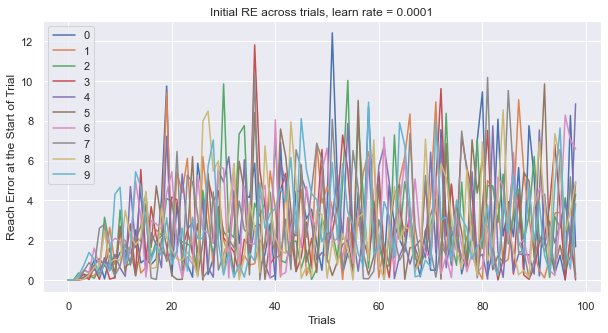

In [10]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trail for target once
NUM_SESSIONS = 10
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [1e-4]
A_RATE = 5e-5
K_RATE = 5e-5
ADAPT_TRIALS = NUM_TRIALS
ADAPT_DEC = False
KW_only = True

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
#             print("fr start of trial")
#             print(fr_start)
#             print("lambda start of trial")
#             print(lambda_trial[:, :, iT, iS])

            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
#             print("cost func params = "+ str(cost_func_params))
            re_startT[iT, iS] = error_costFunc(cost_func_params)
#             print("re start = " + str(re_startT[iT, iS]))

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("cursor start = " + str(cursor_start[:, :, iT, iS]) )

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, :, iT], NUM_RUNS)
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
#             print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        # display stuff
#         print("target position:")
#         print(target_trial)
#         print("cursor end: ")
#         print(cursor_end)
#         print("cursor start: ")
#         print(cursor_start)

        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))
        #     plt.show()
        
#         plt.figure(2*pidx + 2, figsize=(fig_x, fig_y))
#         plt.plot(np.arange(NUM_TRIALS-20-1, NUM_TRIALS-1, 1), re_startT[NUM_TRIALS-1-20:NUM_TRIALS-1, iS])
#         plt.xlabel('Trials' )#, color='white')
#         plt.ylabel('Reach Error at Last 20 Trials')#, color='white')
#         plt.title('Ending RE across trials | learn rate = ' + str(lambda_rate) + '| Decoder Adapt = ' + str(ADAPT_DEC)) #, color = 'white')
#         #     plt.show()

    

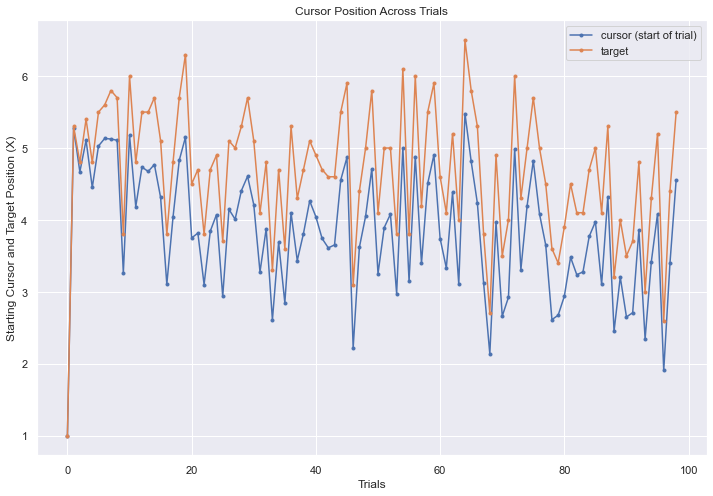

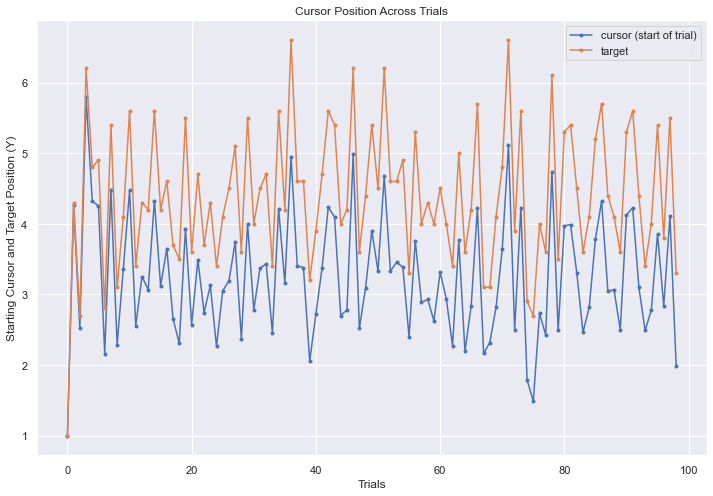

In [11]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Cursor Position Across Trials')
plt.show()


# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

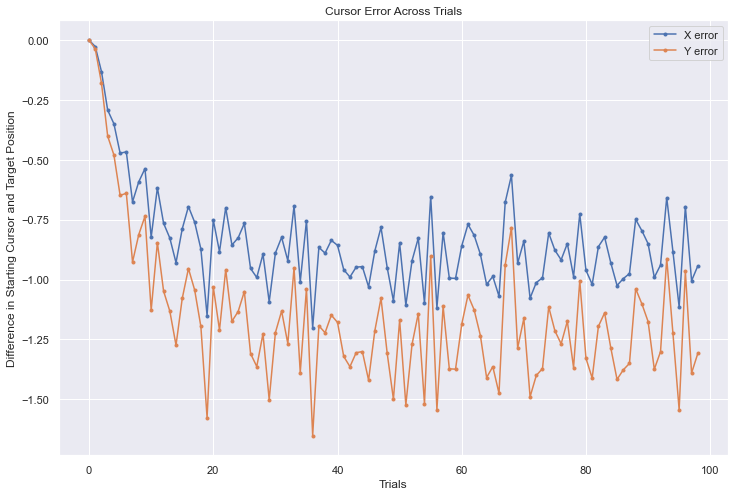

In [12]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

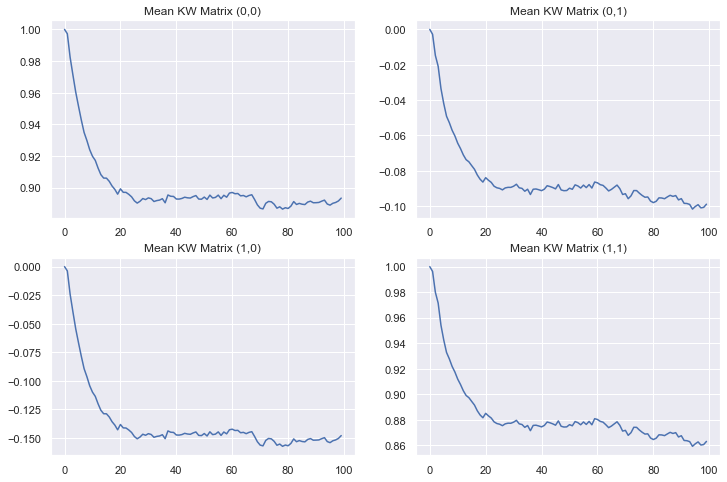

In [13]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

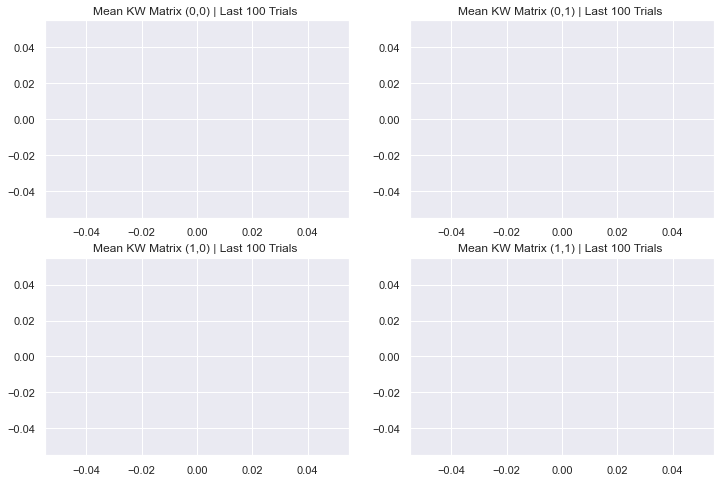

In [14]:

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")

plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [15]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 2.5652846538401026
Session # 1| RE = 2.5184366696942253
Session # 2| RE = 2.708795639912477
Session # 3| RE = 2.5568172373353883
Session # 4| RE = 2.4877354694882587
Session # 5| RE = 2.447678942318
Session # 6| RE = 2.6642595739017945
Session # 7| RE = 2.5020776041772685
Session # 8| RE = 2.568020329794595
Session # 9| RE = 2.684876687918232
